In [ ]:
import time
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_folder_path = "/content/drive/MyDrive/APS360_Project/train_set"
validation_folder_path = "/content/drive/MyDrive/APS360_Project/val_set"
test_folder_path = "/content/drive/MyDrive/APS360_Project/test_set"

In [ ]:
# resize to 64 by 64 and convert to tensor
transformation = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:
train_set = datasets.ImageFolder(root=train_folder_path, transform=transformation)
val_set = datasets.ImageFolder(root=validation_folder_path, transform=transformation)
test_set = datasets.ImageFolder(root=test_folder_path, transform=transformation)
classes = train_set.classes
classes

['Capacitor', 'LED', 'Potentiometer', 'Resistor', 'Transistor']

In [22]:
# helper functions
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_accuracy(model, train_loader=None, other_loader=None, train=False):
    if train:
        data = train_loader
    else:
        data = other_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        #############################################
        # #To Enable GPU Usage
        # if  torch.cuda.is_available():
        #   torch.use_cuda
        #   imgs = imgs.cuda()
        #   labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


In [ ]:
def get_model(name=str, num_classes=int, dropout_rate=0.25):
  model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
  model.name = name
  num_classes = len(classes)
  model.fc =nn.Sequential(
                  nn.Dropout(0.25),
                  nn.Linear(model.fc.in_features, num_classes)
  )

  device = torch.device("cpu")
  model = model.to(device)
  return model

In [20]:
def train_net(model, train_set, val_set, test_set, learning_rate=0.001, batch_size=16, num_epochs=15):
  np.random.seed(42)
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

  losses, train_acc, val_acc = [], [], []
  start_time = time.time()
  n=1
  # training
  for epoch in range(num_epochs):
      total_loss = 0
      number_of_samples = 0
      for imgs, labels in iter(train_loader):
          #############################################
          #To Enable GPU Usage
          # if torch.cuda.is_available():
          #   torch.use_cuda
          #   imgs = imgs.cuda()
          #   labels = labels.cuda()
          #############################################
          out = model(imgs)             # forward pass
          loss = criterion(out, labels) # compute the total loss
          total_loss += loss.item() * imgs.size(0)        # sum the losses in a batch
          number_of_samples += imgs.size(0)               # add one more sample count
          loss.backward()                                 # backward pass (compute parameter updates)
          optimizer.step()                                # make the updates for each parameter
          optimizer.zero_grad()                           # a clean up step for PyTorch

          # save the current training information

      losses.append(float(total_loss)/(number_of_samples))             # compute *average* loss
      train_acc.append(get_accuracy(model, train_loader=train_loader, train=True)) # compute training accuracy
      val_acc.append(get_accuracy(model, other_loader=val_loader, train=False))  # compute validation accuracy
      print(("Epoch {}: Train acc: {} |"+"Validation acc: {}").format(
              epoch + 1,
              train_acc[-1],
              val_acc[-1]))
      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # plotting
  plt.title("Training Curve")
  plt.plot(range(1 ,num_epochs+1), losses, label="Train")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Accurancy Curve")
  plt.plot(range(1 ,num_epochs+1), train_acc, label="Training")
  plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))


In [ ]:
model = get_model("ResNet", len(classes))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 64.0MB/s]


Epoch 1: Train acc: 0.7576601671309192 |Validation acc: 0.6589595375722543
Epoch 2: Train acc: 0.7316620241411328 |Validation acc: 0.6589595375722543
Epoch 3: Train acc: 0.7474466109563602 |Validation acc: 0.6589595375722543
Epoch 4: Train acc: 0.7428040854224698 |Validation acc: 0.6965317919075145
Epoch 5: Train acc: 0.7613741875580315 |Validation acc: 0.653179190751445
Epoch 6: Train acc: 0.7390900649953575 |Validation acc: 0.684971098265896
Epoch 7: Train acc: 0.766016713091922 |Validation acc: 0.6994219653179191
Epoch 8: Train acc: 0.7298050139275766 |Validation acc: 0.6358381502890174
Epoch 9: Train acc: 0.7325905292479109 |Validation acc: 0.6473988439306358
Epoch 10: Train acc: 0.7455896007428041 |Validation acc: 0.6734104046242775
Epoch 11: Train acc: 0.7688022284122563 |Validation acc: 0.6763005780346821
Epoch 12: Train acc: 0.7502321262766946 |Validation acc: 0.6473988439306358
Epoch 13: Train acc: 0.7372330547818013 |Validation acc: 0.6647398843930635
Epoch 14: Train acc: 0.7

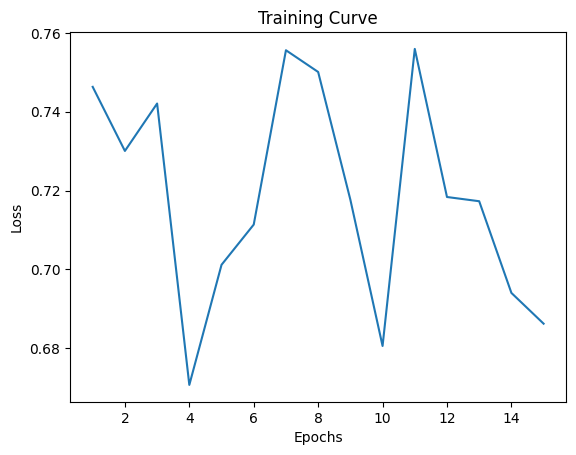

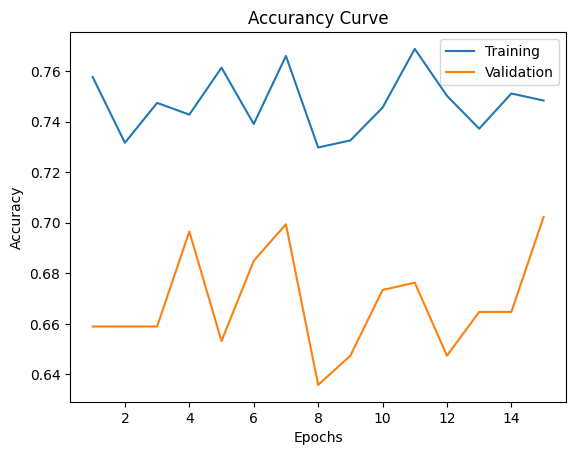

Final Training Accuracy: 0.7483751160631383
Final Validation Accuracy: 0.7023121387283237


In [ ]:
# train with the default set of parameters
train_net(model, train_set, val_set, test_set)

In [23]:
# get test_loader
np.random.seed(42)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

# get the model with best validation acc so far epoch = 14 because this counts from 0
model_path = get_model_name("ResNet",16, 0.001, 14)
state = torch.load(model_path)
model.load_state_dict(state)
accuracy = get_accuracy(model, other_loader=test_loader, train=False)
print(f"the test accuracy is {accuracy}")

the test accuracy is 0.6852941176470588
